### Prediction of Cost of Shipment at DB Schenker

**Introduction**


DB Schenker acts mostly as an intermediary between customers who want to ship some goods and carriers who transport the goods.
In land transport, dispatchers receive orders of shipments and find suitable carriers. This is a process that relies almost entirely on human decisions and interactions. The dispatcher has some tools to access a list of available carriers, and contacts them until he finds someone with whom he agrees on a price. When the price is agreed, the carrier takes the responsibility of delivering the given shipment from the origin to the destination.
It is easy to imagine that deciding the price for a shipment is not an easy task.

Hence it is important to build a model to predict the price that the dispatchers can use as a guideline.


**Goal of the Project**

To build an accurate model to predict the shipping costs of the transport using the land transport data obtained from January 2017 till January 2019 in China.

**The Problem and Matric Selection**

Prediction of the shipping cost is a regression problem and the matrics MSE and MAE can be used to solve this.

**Structure of the notebook**

1. Load Data and Packages
2. Exploring the data
3. Cleaning Data
4. Analyzing the Test Variable (Cost)
5. Feature Transformation/Engineering
6. Modeling and Predictions
7. Summary

### Importing the Libraries

In [38]:
#pip install statsmodels

In [39]:
#pip install geopy

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
import geopy.distance

from sklearn.preprocessing import StandardScaler

#Import linear regression from sklearn library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format

/tmp/ipykernel_553/4023404252.py:6: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


**Loading the data**

In [3]:
df_train = pd.read_csv("data/train_data.csv", sep = ";")

### Exploring the data

In [5]:
# reading the data set
df_train.head(10)

In [4]:
df_train.tail()

In [44]:
#Checking for how many rows and columns
df_train.shape

(251155, 9)

In [45]:
#Checking for the column names
df_train.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr',
       'shipping_date', 'cost'],
      dtype='object')

In [3]:
#Checking for null values in each column
df_train.isnull().sum()

origin_latitude          0
origin_longitude         0
destination_latitude     0
destination_longitude    0
weight                   0
loading_meters           0
is_adr                   0
shipping_date            0
cost                     0
dtype: int64

The above results shows that there are no null values.

In [4]:
# Checking for type of data present in the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251155 entries, 0 to 251154
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   origin_latitude        251155 non-null  float64
 1   origin_longitude       251155 non-null  float64
 2   destination_latitude   251155 non-null  float64
 3   destination_longitude  251155 non-null  float64
 4   weight                 251155 non-null  float64
 5   loading_meters         251155 non-null  float64
 6   is_adr                 251155 non-null  bool   
 7   shipping_date          251155 non-null  object 
 8   cost                   251155 non-null  float64
dtypes: bool(1), float64(7), object(1)
memory usage: 15.6+ MB


The above information shows that except the variable "is_adr" (is it a dangerous good?), all other variables are in float form.

In [5]:
# Checking for unique values
df_train.nunique()

origin_latitude          776
origin_longitude         912
destination_latitude     803
destination_longitude    978
weight                   582
loading_meters           310
is_adr                     1
shipping_date            731
cost                     979
dtype: int64

In [6]:
# Finding the descriptive statistics
df_train.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,cost
count,"251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00"
mean,25.70,108.93,25.58,108.97,0.41,0.17,0.34
std,1.78,2.09,1.98,2.30,0.13,0.06,0.13
min,21.71,102.97,21.65,103.00,0.05,0.00,0.02
25%,24.31,107.34,23.78,107.18,0.33,0.20,0.25
50%,25.65,108.89,25.64,109.40,0.47,0.20,0.33
75%,26.91,110.46,27.17,110.75,0.49,0.20,0.41
max,30.22,114.21,30.40,114.25,1.00,0.99,2.35


The mean value of the cost is 0.34. 

In [7]:
bool_features=df_train[['is_adr']]
bool_features.describe()

,is_adr
count,251155
unique,1
top,True
freq,251155


### Cleaning the data

**Changing the variable "is_adr" from Boolean values to integer**

Changing the boolean value to numeric will help for further visualization and analysis

In [6]:
df_train["is_adr"] = df_train["is_adr"].astype(int)

**Changing Time to datetime stamp**

In [7]:
df_train['shipping_date'] = pd.to_datetime(df_train['shipping_date'], format='%Y-%m-%d')

In [108]:
#df_train['shipping_date'] = df_train['shipping_date'].astype(float, errors = 'raise')

**Extracting year, month, and day from the date column**

In [8]:
df_train = df_train.assign(
    timestamp = lambda x: pd.to_datetime(x['shipping_date']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofweek = lambda x: x['shipping_date'].dt.dayofweek
)

In [11]:
df_train.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost,timestamp,year,month,day,dayofweek
0,27.22,105.59,26.91,108.67,0.51,0.20,1,2017-04-24,0.25,2017-04-24,2017,4,24,0
1,25.00,109.79,25.34,108.59,0.48,0.20,1,2017-07-27,0.25,2017-07-27,2017,7,27,3


### Analysing the data

Where is the Origin of shipment (Country) takeplace?

In [20]:
# # Geographical Plot
# fig = px.scatter_mapbox(df_train, lat="origin_latitude", lon="origin_longitude", color="cost", center={'lat':23, 'lon':115},
#                         zoom=5, height=400, width=800, title="Cost in Origin place")
# # earth background
# fig.update_layout(
#     mapbox_style="open-street-map",
#     )
# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":30,"l":0,"b":50})

# fig.show()
# #fig.write_image("images/map1.png")

Where is the destination of shipment (Country) takeplace?

In [19]:
# fig = px.scatter_mapbox(df_train, lat="destination_latitude", lon="destination_longitude", color="cost", center={'lat':23, 'lon':115},
#                         zoom=5, height=400, width=800, title="Cost in Delivery place")
# # earth background
# fig.update_layout(
#     mapbox_style="open-street-map",
#     )
# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":30,"l":0,"b":50})


The geographical map shows that the origin and destination of the data is obtained from China.

**Exploring the relationship between two variables using pair plots** 

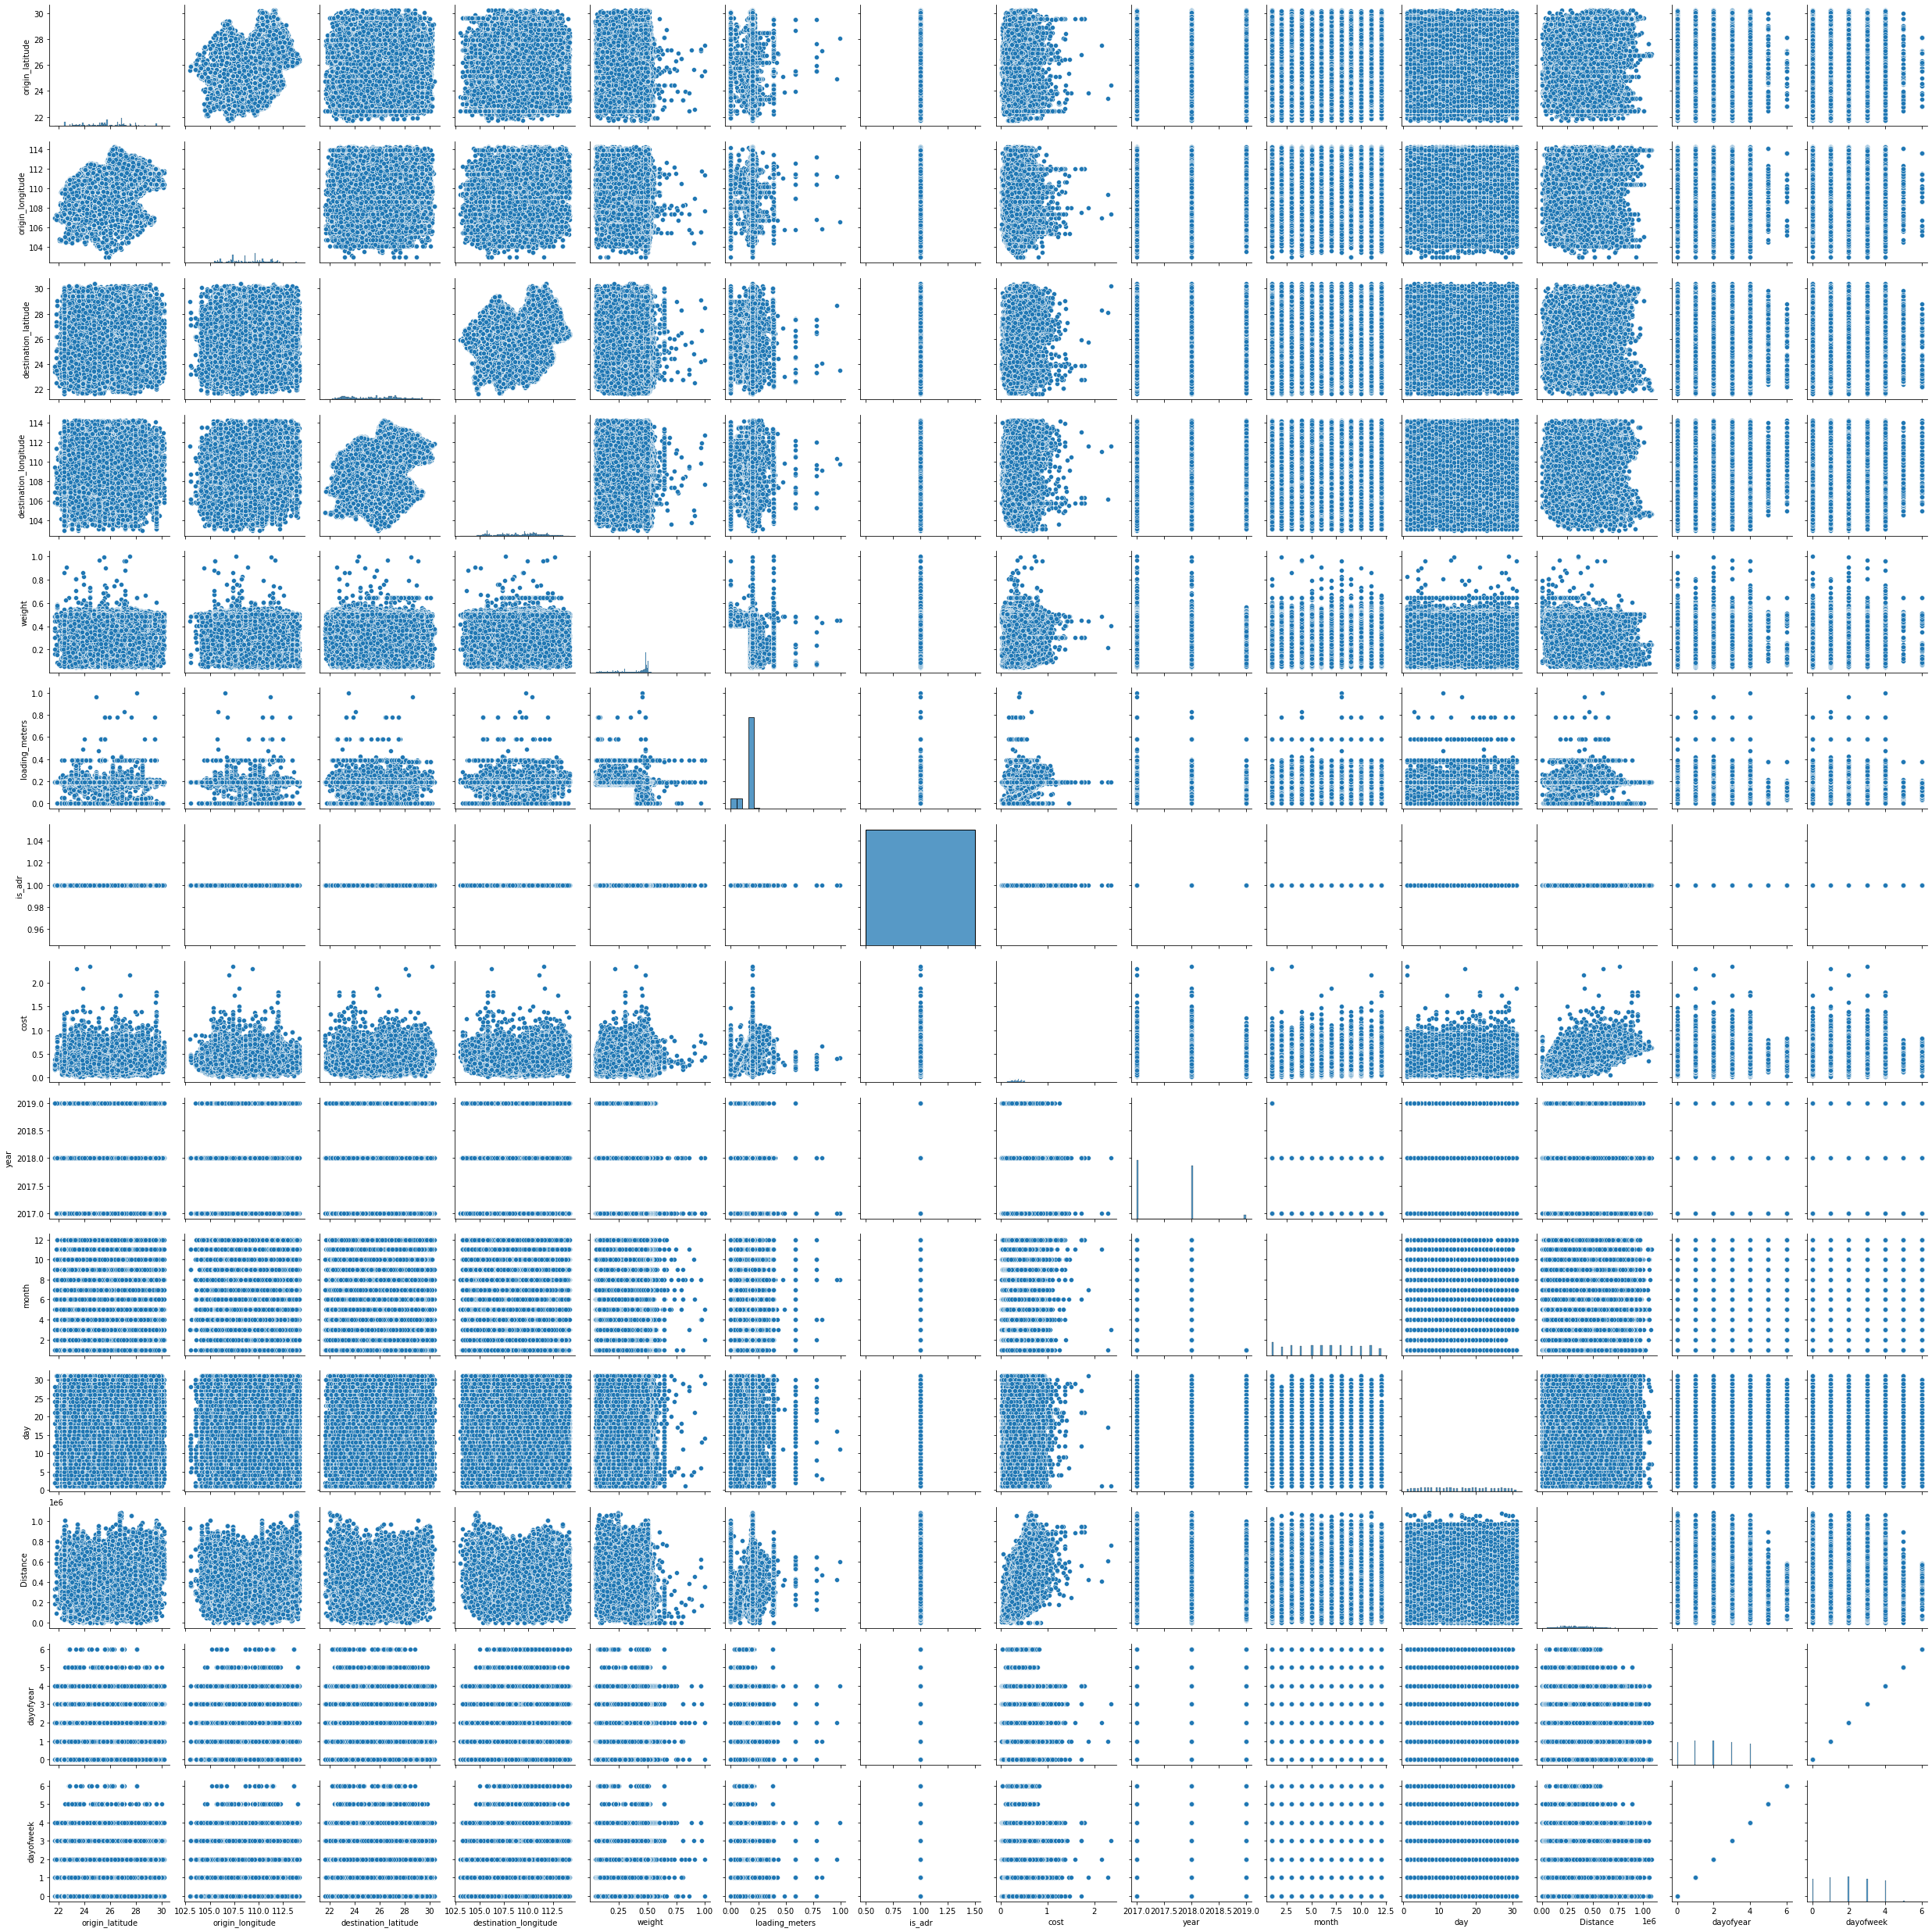

In [79]:
sns.pairplot(df_train)

The pairplot shows the variations in each plot. The plots are in matrix format where the row name represents x axis and column name represents the y axis. The main-diagonal subplots are the univariate histograms (distributions) for each attribute.

Pair plot is used to understand the best set of features to explain a relationship between two variables or the  separated clusters. It also helps to form some simple classification models by drawing some simple lines or make linear separation in our data-set.


**Correlation heat map**

Correlation heatmaps is used to find the relationships between variables and to understand the strength of these relationships. 

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.corr(),cbar=True,annot=True,cmap='Blues')
plt.title('Correlation heat map', fontweight='bold')

**Daily Shipping Cost**

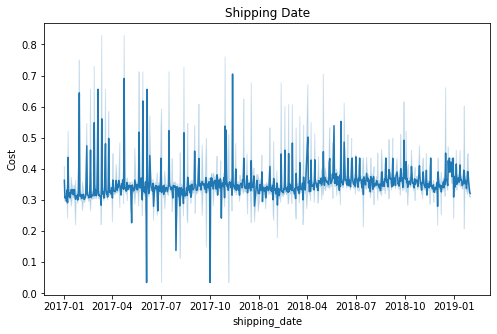

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['shipping_date'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='Shipping Date', ylabel=r'Cost');

From the above graph the daily shipping cost shows that most of the value falls between 0.3 and 0.35. The lowest cost was recorded in October 2017 and the highest cost recorded in March 2017.

**Yearly Shipping Cost**

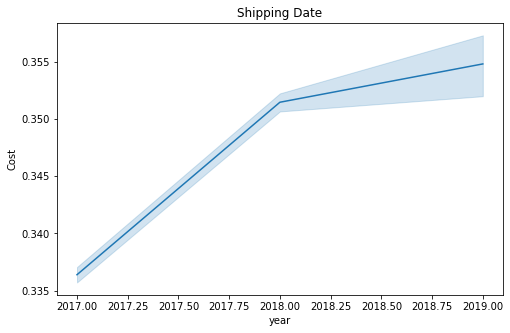

In [24]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['year'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='Shipping Date', ylabel=r'Cost');

Yearly shipping cost shows that there is an increase in the cost every year and the cost is maximum in 2019

**Monthly Shipping Cost**

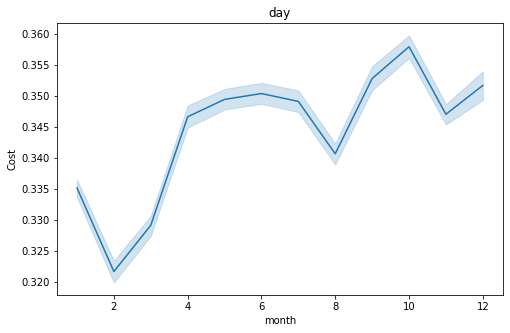

In [26]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['month'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='day', ylabel=r'Cost');

Monthly cost shows no clear trend like continuously increasing or decreasing but it is random.

### Distribution of Cost

/root/.pyenv/versions/3.9.4/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


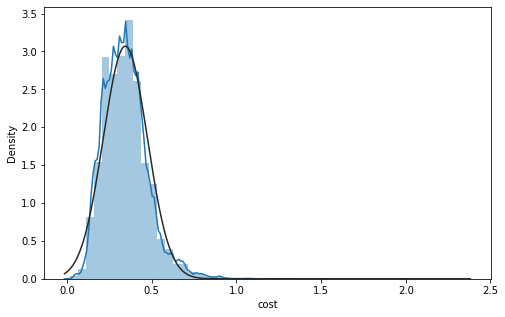

In [12]:
sns.distplot(df_train['cost'], fit=norm);

The distribution of cost curve shows that the cost variable is slightly right skewed.

**Comparing Weight and Cost**

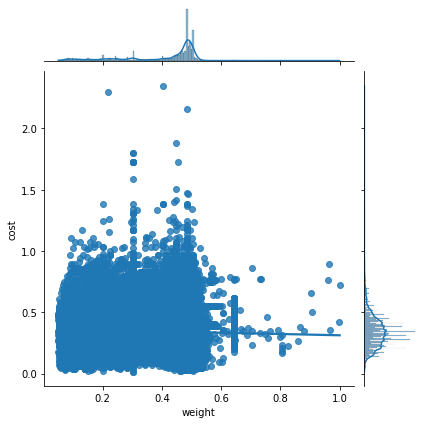

In [26]:
# Weight vs Cost
sns.jointplot(x=df_train['weight / kg'], y=df_train['cost'], kind='reg')

The plot shows that most of the shipments are between 0.05 - 0.6 kg approaximately and there is not much linearity between the weight and cost. 

**Comparing Length of the shipment to Cost**

<AxesSubplot:xlabel='loading_meters', ylabel='cost'>

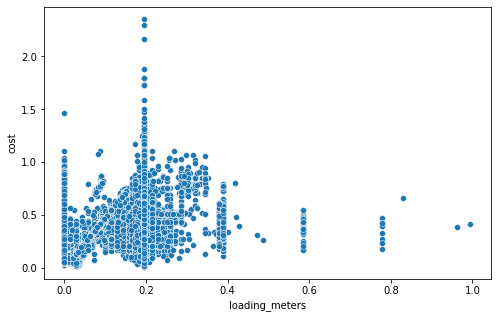

In [63]:
sns.scatterplot(data=df_train, x="loading_meters", y="cost")

The scatter plot of the distance between the length of the shipment and cost also shows that there is no linear relationship between them. But there are some concrete values approaximately around 0.01, 0.2, 0.39, 0.59 and 0.79. This shows that at these values costs are increasing.

### Feature Engineering

As the distance between the origin of shipment and destination of shipment can influence the cost of shipping, I am creating a new column called "Distance" which is the difference of longitude and lattitude of origin of shipment between that of the destination.

In [10]:
df_train['Distance']=[round(geopy.distance.distance((df_train.origin_latitude[i], df_train.origin_longitude[i]),(df_train.destination_latitude[i], df_train.destination_longitude[i])).m,2) for i in df_train.index]

In [11]:
df_train.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,cost,timestamp,year,month,day,dayofweek,Distance
0,27.22,105.59,26.91,108.67,0.51,0.20,1,2017-04-24,0.25,2017-04-24,2017,4,24,0,"307,445.69"
1,25.00,109.79,25.34,108.59,0.48,0.20,1,2017-07-27,0.25,2017-07-27,2017,7,27,3,"126,699.74"


In [12]:
df_train.drop(["timestamp", "shipping_date"], axis=1, inplace=True)

In [13]:
df_train.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr', 'cost',
       'year', 'month', 'day', 'dayofweek', 'Distance'],
      dtype='object')

**Feature Selection**

I use all of the features for the modelling as all of them have influence to predict the cost of the shipment

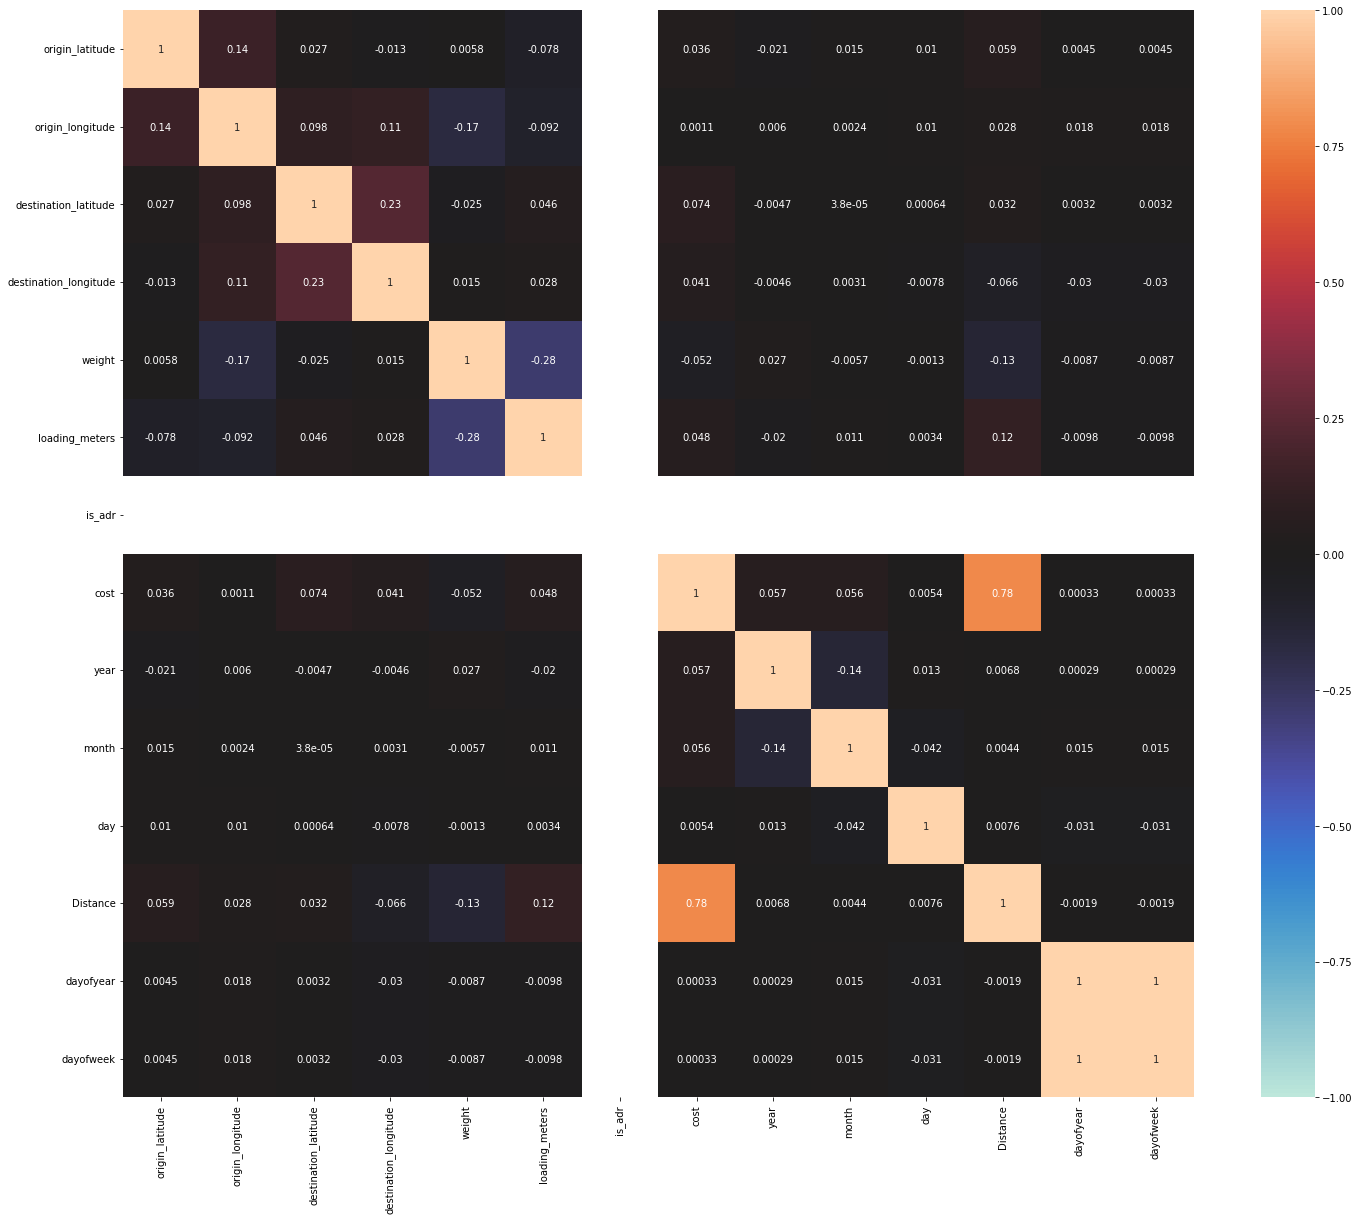

In [91]:
plt.figure(figsize=[24,20])
sns.heatmap(df_train.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

### Data Manipulation

In [53]:
df_train.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,cost,year,month,day,dayofweek,Distance
0,27.22,105.59,26.91,108.67,0.51,0.20,1,0.25,2017,4,24,0,"307,445.69"
1,25.00,109.79,25.34,108.59,0.48,0.20,1,0.25,2017,7,27,3,"126,699.74"


In [54]:
df_train.to_csv("data/Trained_df_train.csv")

In [55]:
df_train['cost']

0        0.25
1        0.25
2        0.28
3        0.28
4        0.55
         ... 
251150   0.51
251151   0.55
251152   0.44
251153   0.31
251154   0.35
Name: cost, Length: 251155, dtype: float64

In [56]:
df_train['cost'].to_csv("data/Cost_df_train.csv")

In [14]:
#Splitting the data intro training & testing sets

y = df_train['cost']
X = df_train.drop('cost', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Original dataset  ---> ',X.shape,y.shape,'\nTraining set  ---> ', X_train.shape,y_train.shape,
'\nTesting set   ---> ', X_test.shape,'', y_test.shape)

Original dataset  --->  (251155, 12) (251155,) 
Training set  --->  (200924, 12) (200924,) 
Testing set   --->  (50231, 12)  (50231,)


**Feature Scaling (Standardization)**

In [15]:
std = StandardScaler()
col_scale = ['Distance']

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
X_test_scaled = scaler.transform(X_test[col_scale])

In [17]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(col_scale, axis=1)], axis=1)

In [18]:
print('Original dataset  ---> ',X.shape,y.shape,'\nTraining set  ---> ', X_train_preprocessed.shape,y_train.shape,
'\nTesting set   ---> ', X_test_preprocessed.shape,'', y_test.shape)

Original dataset  --->  (251155, 12) (251155,) 
Training set  --->  (200924, 12) (200924,) 
Testing set   --->  (50231, 12)  (50231,)


### Evaluation Metric Selection

Mean absolute error, Mean squared error are Root mean squared error selected as metric for model evaluation.

### Modelling

**Linear Regression model with statsmodels**

Multivariate Linear Regression Model

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
# Instantiate our model 
lin_reg = LinearRegression()

# Train the model using our data
lin_reg.fit(X_train_preprocessed, y_train)

LinearRegression()

In [21]:
lin_reg.intercept_

-27.421944839625816

In [22]:
lin_reg.coef_

array([ 1.03557776e-01, -6.71435488e-04, -2.10598651e-03,  2.15659712e-03,
        5.15497093e-03,  3.14316013e-02, -8.91052916e-02, -1.73472348e-16,
        1.35722372e-02,  2.31437988e-03,  2.85945125e-05,  4.35232962e-04])

In [23]:
y_pred = lin_reg.predict(X_test)

/root/neuefische/Cost-Prediction/.venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [24]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)

        Actual  Predicted
231756    0.31     256.66
100391    0.37     158.35
25222     0.53     261.58
115610    0.36      93.70
66738     0.51      61.24
...        ...        ...
83659     0.39     175.63
194385    0.44     240.20
24511     0.14      31.59
95899     0.41     273.30
127998    0.21     120.27

[50231 rows x 2 columns]


**Evaluating the Multivariate Model**


In [25]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 135.58
Mean squared error: 24753.90
Root mean squared error: 157.33


### Random Forest

In [32]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_jobs = -1, random_state = 42, n_estimators = 500, verbose = 1)
regr.fit(X_train_preprocessed, y_train)
regr.score(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   18.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   21.1s finished


0.9728524915799112

In [33]:
#from sklearn import metrics
pred1 = regr.predict(X_test) 

/root/neuefische/Cost-Prediction/.venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


In [34]:
mae = mean_absolute_error(y_test, pred1)
mse = mean_squared_error(y_test, pred1)
rmse = np.sqrt(mse)

print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 0.81
Mean squared error: 0.67
Root mean squared error: 0.82


In [37]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': pred1})
print(results)

        Actual  Predicted
231756    0.31       1.19
100391    0.37       1.19
25222     0.53       1.10
115610    0.36       1.16
66738     0.51       1.14
...        ...        ...
83659     0.39       1.13
194385    0.44       1.13
24511     0.14       1.10
95899     0.41       1.15
127998    0.21       1.15

[50231 rows x 2 columns]


In [38]:
#results.to_csv("data/results_test.csv")

### Model Selection

From the modelling results it is clear that Random Forest works better than the linear model. So further future prediction, random forest will be selected. 

### Prediction on given Test data 

In [57]:
df_test = pd.read_csv("data/test_data.csv", sep = ";")

In [96]:
df_test.head(10)

In [59]:
#Checking for how many rows and columns
df_test.shape

(62789, 8)

In [60]:
#Checking for the column names
df_test.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr',
       'shipping_date'],
      dtype='object')

In [61]:
#Checking for null values in each column
df_test.isnull().sum()

origin_latitude          0
origin_longitude         0
destination_latitude     0
destination_longitude    0
weight                   0
loading_meters           0
is_adr                   0
shipping_date            0
dtype: int64

In [62]:
# Checking for type of data present in the dataframe
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62789 entries, 0 to 62788
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   origin_latitude        62789 non-null  float64
 1   origin_longitude       62789 non-null  float64
 2   destination_latitude   62789 non-null  float64
 3   destination_longitude  62789 non-null  float64
 4   weight                 62789 non-null  float64
 5   loading_meters         62789 non-null  float64
 6   is_adr                 62789 non-null  bool   
 7   shipping_date          62789 non-null  object 
dtypes: bool(1), float64(6), object(1)
memory usage: 3.4+ MB


In [63]:
# Checking for unique values
df_test.nunique()

origin_latitude          718
origin_longitude         826
destination_latitude     786
destination_longitude    931
weight                   535
loading_meters           246
is_adr                     1
shipping_date            659
dtype: int64

In [64]:
# Finding the descriptive statistics
df_test.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters
count,"62,789.00","62,789.00","62,789.00","62,789.00","62,789.00","62,789.00"
mean,25.70,108.92,25.58,108.97,0.41,0.17
std,1.79,2.08,1.98,2.29,0.13,0.06
min,21.71,102.97,21.65,103.18,0.05,0.00
25%,24.31,107.34,23.79,107.18,0.33,0.20
50%,25.70,108.81,25.61,109.40,0.47,0.20
75%,26.91,110.43,27.17,110.73,0.49,0.20
max,30.40,114.21,30.40,114.25,0.95,1.00


In [65]:
bool_features=df_test[['is_adr']]
bool_features.describe()

,is_adr
count,62789
unique,1
top,True
freq,62789


In [66]:
df_test["is_adr"] = df_test["is_adr"].astype(int)

In [67]:
df_test['shipping_date'] = pd.to_datetime(df_test['shipping_date'], format='%Y-%m-%d')

In [68]:
df_test = df_test.assign(
    timestamp = lambda x: pd.to_datetime(x['shipping_date']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofweek = lambda x: x['shipping_date'].dt.dayofweek
)

In [69]:
df_test['Distance']=[round(geopy.distance.distance((df_test.origin_latitude[i], df_test.origin_longitude[i]),(df_test.destination_latitude[i], df_test.destination_longitude[i])).m,2) for i in df_test.index]

In [70]:
df_test.head(2)

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,is_adr,shipping_date,timestamp,year,month,day,dayofweek,Distance
0,25.33,110.99,22.66,109.60,0.20,0.20,1,2017-01-02,2017-01-02,2017,1,2,0,"327,799.51"
1,26.06,106.17,24.87,111.16,0.15,0.20,1,2017-01-02,2017-01-02,2017,1,2,0,"518,811.97"


In [71]:
df_test.drop(["timestamp", "shipping_date"], axis=1, inplace=True)

In [72]:
df_test.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr', 'year',
       'month', 'day', 'dayofweek', 'Distance'],
      dtype='object')

### Data Manipulation

## Scaling

In [83]:
std = StandardScaler()
col_scale = ['Distance']

In [85]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[col_scale])
df_test_scaled = scaler.transform(df_test[col_scale])

In [86]:
# Concatenating scaled and dummy columns 
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(col_scale, axis=1)], axis=1)
df_test_preprocessed = np.concatenate([df_test_scaled, df_test.drop(col_scale, axis=1)], axis=1)

## Predictive Modelling

In [89]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_jobs = -1, random_state = 42, n_estimators = 500, verbose = 1)
regr.fit(X_train_preprocessed, y_train)
regr.score(X_train_preprocessed, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   23.0s finished


0.9728524915799112

In [90]:
#from sklearn import metrics
pred1 = regr.predict(df_test) 

/root/neuefische/Cost-Prediction/.venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.6s finished


In [94]:
results = pd.DataFrame({'Predicted': pred1})
print(results)

       Predicted
0           1.16
1           1.16
2           1.16
3           1.16
4           1.16
...          ...
62784       1.18
62785       1.18
62786       1.18
62787       1.18
62788       1.18

[62789 rows x 1 columns]


In [95]:
results.to_csv("data/Predicted_test_results.csv")